# Azimuthal integration

Azimuthal integration is a common analysis step with 2D detector data.
The aim is to get an average of the radial profile around the beam, turning rings into peaks:

![azimuthal integration diagram](azimuthal-int-diagram.png)

The [PyFAI package](https://www.silx.org/doc/pyFAI/latest/), developed at ESRF, performs azimuthal integration with a range of different options and methods.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from extra_geom import LPD_1MGeometry
from pyFAI.integrator.azimuthal import AzimuthalIntegrator

mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (8, 6)

This example is written with LPD geometry, but the same method should work with AGIPD and DSSC (support for other detectors is still to come).

In [2]:
quadpos = [(11.4, 299), (-11.5, 8), (254.5, -16), (278.5, 275)]  # in mm
geom = LPD_1MGeometry.from_quad_positions(quadpos)

We'll generate an idealised detector image with two rings - one sharper, and one broader.
This is where you'd normally load real detector data.

In [3]:
# Generate a simple pattern with a sharper ring and a broader one
px, py, pz = np.moveaxis(geom.get_pixel_positions(), -1, 0)

r = np.sqrt((px ** 2) + (py ** 2))

a1, b1, c1 = 1, 0.15, 0.08
a2, b2, c2 = 1, 0.06, 0.002
frame = (
    a1 * np.exp(- ((r-b1) ** 2) / (2 * c1 ** 2)) +
    a2 * np.exp(- ((r-b2) ** 2) / (2 * c2 ** 2))
)

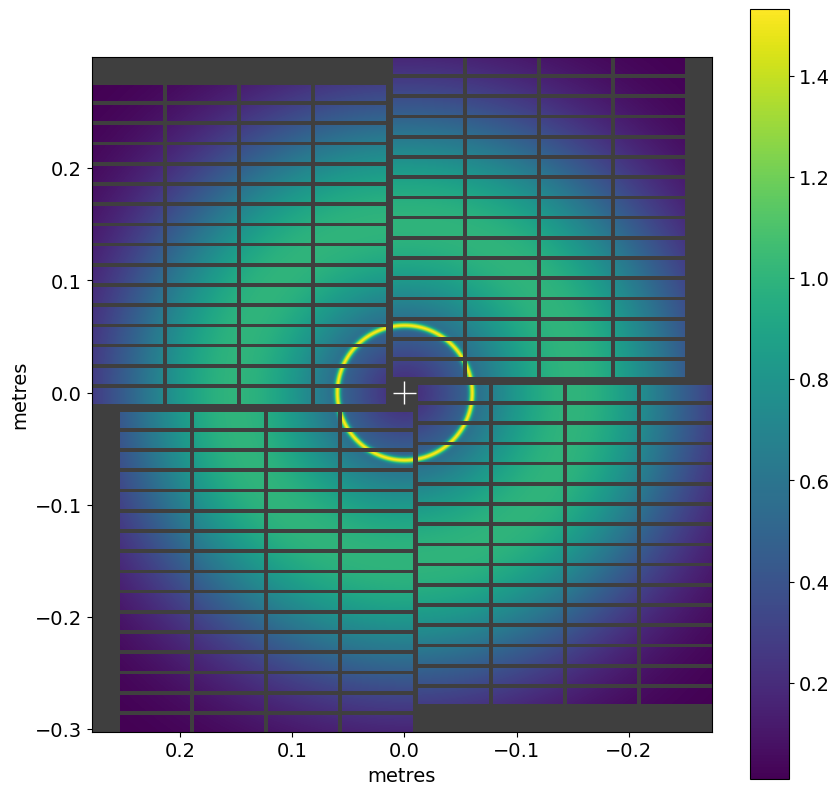

In [4]:
geom.plot_data_fast(frame, axis_units='m');

To use PyFAI, we'll get a PyFAI detector object, and use that to create an AzimuthalIntegrator:

In [5]:
ai = AzimuthalIntegrator(
    detector=geom.to_pyfai_detector(),
    dist=0.2,  # sample-detector distance (m)
    wavelength=(12.3984 / 9.3) * 1e-10  # wavelength (m)
)

`wavelength` is optional, but some PyFAI features (like giving results in terms of Q) require it.
The example above shows how to convert a photon energy (9.3 keV) to a wavelength.

The data we'll give PyFAI is not assembled into a 2D image, because PyFAI knows the position of every pixel:

In [6]:
frame.shape  # 16 separate modules

(16, 256, 256)

Now we can do the azimuthal integration:

Text(0.5, 0, 'radius (mm)')

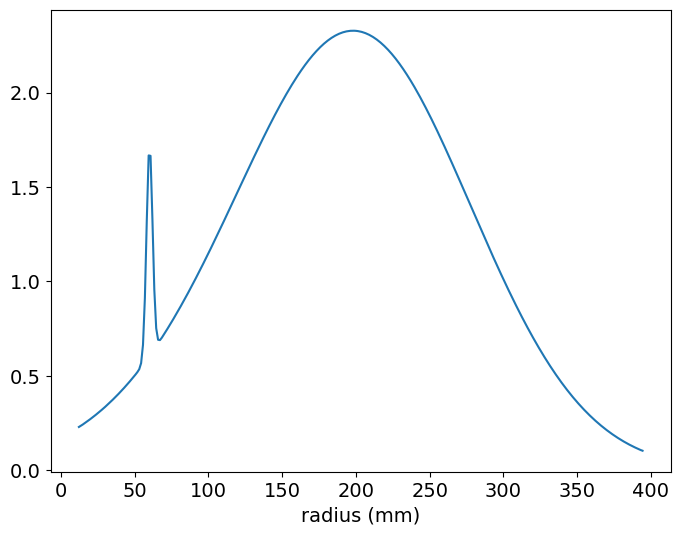

In [7]:
rint, I = ai.integrate1d(
    frame.reshape(16*256, 256),
    npt=300,
    unit="r_mm",
)

plt.plot(rint, I)
plt.xlabel('radius (mm)')

The two rings have become two peaks.

PyFAI can also unroll the image around the centre, which can be useful to check if your geometry is centred correctly:

Text(0, 0.5, 'chi (degrees)')

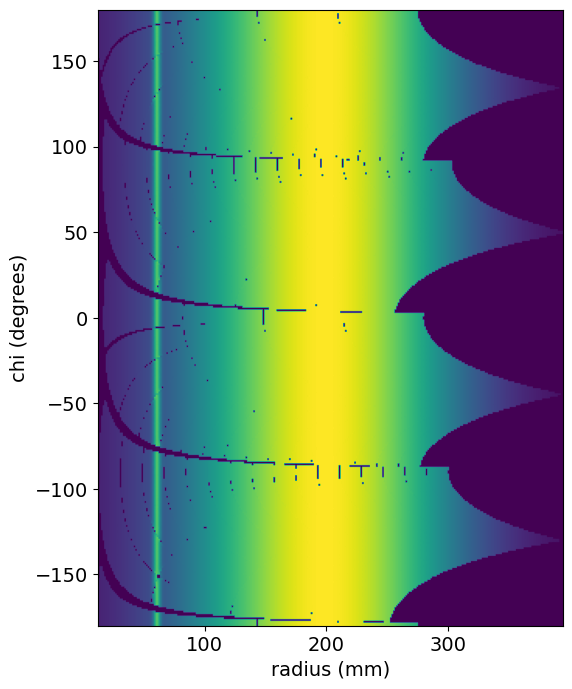

In [8]:
I, rint2d, chi = ai.integrate2d(
    frame.reshape(16*256, 256),
    npt_rad=300,
    unit="r_mm",
    method=("pseudo", "histogram", "cython"),
)

plt.figure(figsize=(6, 8))
plt.imshow(I, aspect='auto',
          extent=(rint2d[0], rint2d[-1], -180, 180))
plt.xlabel('radius (mm)')
plt.ylabel('chi (degrees)')

`integrate2d` turns each ring into a vertical stripe.
In this case, it works perfectly, because we generated the rings using the same geometry we've given to PyFAI.

Let's see what happens if the geometry information is not correct.
In the code below, we shift the whole geometry by 5 mm (10 pixels) before passing it to PyFAI, so the centre position is wrong.

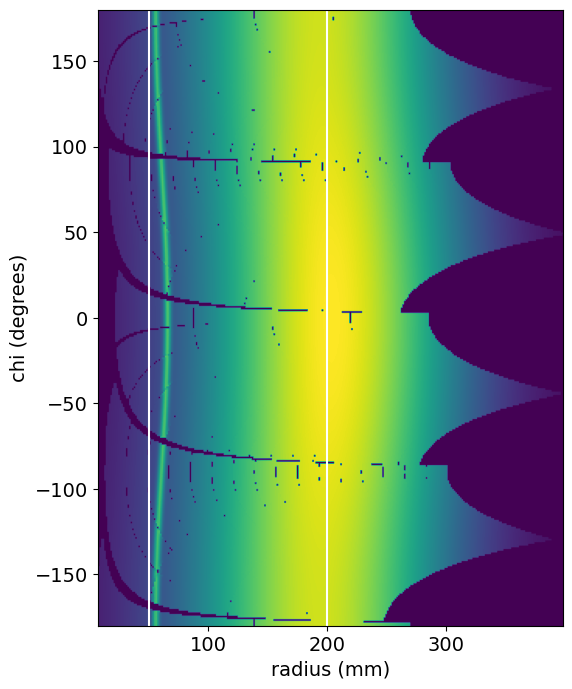

In [9]:
# .offset() shifts the geometry, so we're giving PyFAI bad pixel positions
ai_bad = AzimuthalIntegrator(
    detector=geom.offset((5e-3, 0)).to_pyfai_detector(),
    dist=0.2,  # sample-detector distance (m)
)

I, rint2d, chi = ai_bad.integrate2d(
    frame.reshape(16*256, 256),
    npt_rad=300,
    unit="r_mm",
    method=("pseudo", "histogram", "cython"),
)

plt.figure(figsize=(6, 8))
plt.imshow(I, aspect='auto',
          extent=(rint2d[0], rint2d[-1], -180, 180))
plt.xlabel('radius (mm)')
plt.ylabel('chi (degrees)')

plt.axvline(50, color='white')  # Vertical lines to highlight the curve
plt.axvline(200, color='white');

The incorrect centre position results in curved stripes, instead of completely straight ones like above.

If you see this with real data, and you have data containing sharp rings, you may be able to use the [centreOptimiser](https://github.com/European-XFEL/geoAssembler/blob/master/docs/centreOptimiser-tutorial.ipynb) routine to improve your geometry.

-----

[PyFAI](https://www.silx.org/doc/pyFAI/latest/) is a very powerful library, with extensive documentation of its own. This example has only scratched the surface. PyFAI's [introductory tutorial](https://www.silx.org/doc/pyFAI/latest/usage/tutorial/Introduction/introduction.html) and [AzimuthalIntegrator API docs](https://www.silx.org/doc/pyFAI/latest/api/pyFAI.html#pyFAI.azimuthalIntegrator.AzimuthalIntegrator) are particularly useful starting points to find out more.